In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys 

sys.path.insert(0, '../../../../scripts/')
import dataframe_analysis as dfa
import create_AR_DeployInst as cdi
import dakota_output as oup

In [53]:
#General plotting variables
metrics = {'enr_u':'Fuel Mass', 'haleu':'HALEU Mass', 'swu':'Total SWU', 
          'haleu_swu':'HALEU SWU', 'waste':'SNF', 'feed':'HALEU Feed'}
colors = ['tab:orange','tab:purple','tab:brown',
         'tab:blue', 'tab:red', 'tab:green',
         'black', 'darkorchid','indigo','peachpuff',
         'navy','tomato']
markers = ['d','o','*', 's','v','P']
time = np.round(np.linspace(0,1499,1499)/12 + 1965,2)

## Transition Start Time
The transition start time ranges from times tep 721-901, in increments of 3 months.

The first part of the analysis compares the results of using the DeployInst and the ManagerInst in Cyclus, comparing 
the results from different methods to deploy the advanced reactors. The second part of the analysis is for just the
results from deploying advanced reactors with the DeployInst, with these results in publsihed literature.

In [3]:
ts_file = "transition_start/transition_start.dat"
ts_data = pd.read_csv(ts_file, sep="\s+",header=0)
ts_data['Year'] = ts_data['ts']/12 + 1965

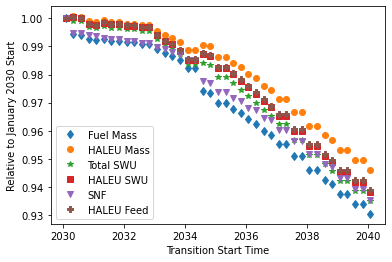

In [4]:
plt.figure
for index, key in enumerate(metrics): 
    plt.plot(ts_data['Year'][20:], ts_data[key][20:]/ts_data[key][20],label=metrics[key], 
            linestyle='None', marker=markers[index])
plt.xlabel('Transition Start Time')
plt.legend()
plt.ylabel('Relative to January 2030 Start')
plt.savefig('figures/ts.pdf')

In [5]:
ts_results = pd.DataFrame(columns=['Metric','Minimum','Maximum','Average','Standard Deviation'])
for key in metrics:
    minimum = ts_data[key].min()
    maximum = ts_data[key].max()
    average = ts_data[key].mean()
    std = ts_data[key].std()
    ts_results.loc[len(ts_results)] = [metrics[key], minimum, maximum, average, std]

In [6]:
ts_results

,Metric,Minimum,Maximum,Average,Standard Deviation
0,Fuel Mass,2.744544e+07,2.950017e+07,2.889884e+07,6.684185e+05
1,HALEU Mass,2.716371e+07,2.874055e+07,2.835784e+07,4.810911e+05
2,Total SWU,9.517457e+08,1.017818e+09,1.000752e+09,2.110616e+07
3,HALEU SWU,9.498443e+08,1.013015e+09,9.971003e+08,1.987717e+07
4,SNF,2.511336e+07,2.684814e+07,2.635850e+07,5.489655e+05
5,HALEU Feed,8.238462e+08,8.779445e+08,8.643595e+08,1.697621e+07


In [7]:
#Deployment scheme
reactors = {}
starts = np.linspace(721,901,61)
for start in starts:
    reactors[str(int(start))] = {'Xe-100':np.zeros(1499), 'MMR':np.zeros(1499),'VOYGR':np.zeros(1499)}
    DI = cdi.convert_xml_to_dict("transition_start/ty_" + str(int(start)) + "_deployinst.xml")
    for key in reactors[str(int(start))]:
        for index, item in enumerate(DI['DeployInst']['prototypes']['val']):
            if item == key:
                build = int(DI['DeployInst']['build_times']['val'][index])
                end = int(DI['DeployInst']['build_times']['val'][index]) + int(DI['DeployInst']['lifetimes']['val'][index])
                if end > 1499:
                    end = 1499
                reactors[str(int(start))][key][build:end] += int(DI['DeployInst']['n_build']['val'][index]) 

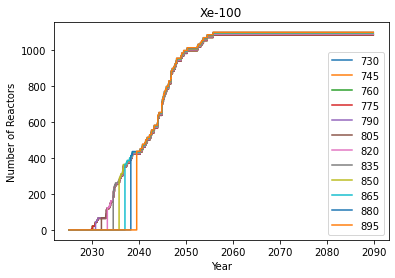

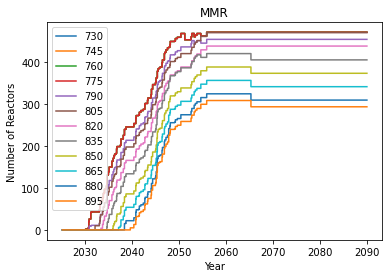

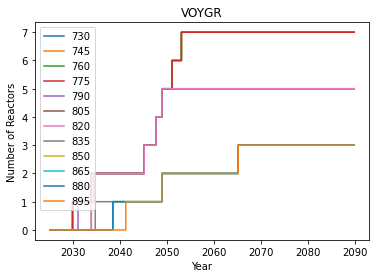

In [65]:
for s_index, start in enumerate(starts[3::5]):
    for index, reactor in enumerate(['Xe-100','MMR','VOYGR']):
        plt.figure(index)
        plt.step(time[721:], reactors[str(int(start))][reactor][721:], 
                 label=str(int(start)))
        plt.legend()
        plt.title(reactor)
        plt.ylabel('Number of Reactors')
        plt.xlabel('Year')
        plt.savefig(f'figures/{reactor}_ts.pdf')

## LWR Lifetime
Vary the percent of LWRs that operate for 80 years, with the other reactors operating for 60 years.
Percent varies between 0-50% in 5% increments

In [12]:
lwr_file = "lwr_lifetime/lwr_lifetime.dat"
lwr_data = pd.read_csv(lwr_file, sep="\s+",header=0)

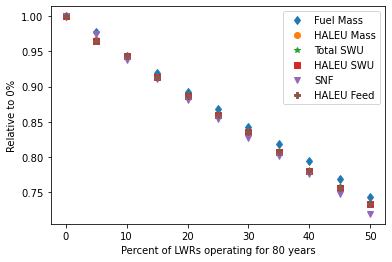

In [13]:
plt.figure
for index, key in enumerate(metrics): 
    plt.plot(lwr_data['lwr'], lwr_data[key]/lwr_data[key][0],label=metrics[key], 
            linestyle='None', marker = markers[index])
plt.xlabel('Percent of LWRs operating for 80 years')
plt.legend()
plt.ylabel('Relative to 0%')
plt.savefig('figures/lwr.pdf')

In [14]:
lwr_results = pd.DataFrame(columns=['Metric','Minimum','Maximum','Average','Standard Deviation'])
for key in metrics:
    minimum = lwr_data[key].min()
    maximum = lwr_data[key].max()
    average = lwr_data[key].mean()
    std = lwr_data[key].std()
    lwr_results.loc[len(lwr_results)] = [metrics[key], minimum, maximum, average, std]

In [15]:
lwr_results

,Metric,Minimum,Maximum,Average,Standard Deviation
0,Fuel Mass,2.110172e+07,2.837110e+07,2.468494e+07,2.404756e+06
1,HALEU Mass,2.069912e+07,2.823230e+07,2.433652e+07,2.489596e+06
2,Total SWU,7.336927e+08,9.980080e+08,8.616883e+08,8.746055e+07
3,HALEU SWU,7.309756e+08,9.970713e+08,8.593369e+08,8.804480e+07
4,SNF,1.853291e+07,2.576681e+07,2.209096e+07,2.386488e+06
5,HALEU Feed,6.333917e+08,8.639585e+08,7.446248e+08,7.628013e+07


In [20]:
#Deployment scheme
lwr_reactors = {}
percents = np.linspace(0,50, 11)
for percent in percents:
    lwr_reactors[str(int(percent))] = {'Xe-100':np.zeros(1499), 'MMR':np.zeros(1499),'VOYGR':np.zeros(1499)}
    DI = cdi.convert_xml_to_dict("lwr_lifetime/AR_DeployInst_lwr_" + str(int(percent)) +".xml")
    for key in lwr_reactors[str(int(percent))]:
        for index, item in enumerate(DI['DeployInst']['prototypes']['val']):
            if item == key:
                start = int(DI['DeployInst']['build_times']['val'][index])
                end = int(DI['DeployInst']['build_times']['val'][index]) + int(DI['DeployInst']['lifetimes']['val'][index])
                if end > 1499:
                    end = 1499
                lwr_reactors[str(int(percent))][key][start:end] += int(DI['DeployInst']['n_build']['val'][index]) 

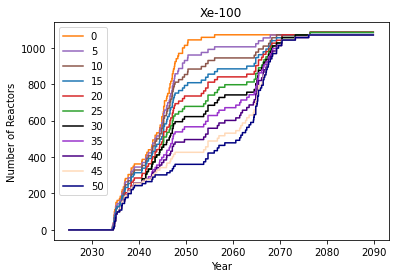

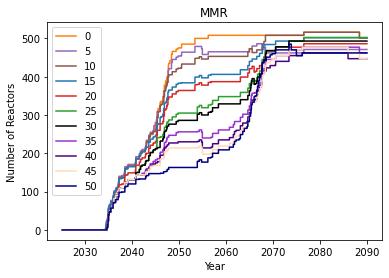

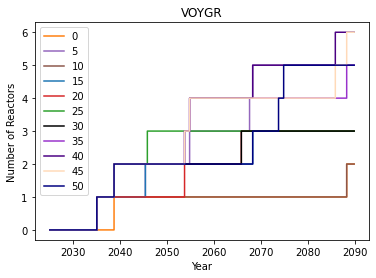

In [60]:
colors = ['tab:orange','tab:purple','tab:brown',
         'tab:blue', 'tab:red', 'tab:green',
         'black', 'darkorchid','indigo','peachpuff',
         'navy','tomato']
for p_index, percent in enumerate(percents):
    for index, reactor in enumerate(['Xe-100','MMR','VOYGR']):
        plt.figure(index)
        plt.step(time[721:], lwr_reactors[str(int(percent))][reactor][721:], 
                 label=str(int(percent)), color=colors[p_index])
        plt.legend()
        plt.title(reactor)
        plt.ylabel('Number of Reactors')
        plt.xlabel('Year')
        plt.savefig(f'figures/{reactor}_lwr.pdf')

## Xe-100 Build Share
The new build share is specified for the Xe-100, ranging from 0-50% 
in increments of 5%. 

In [29]:
xe100_file = "xe-100/xe100_build.dat"
xe100_data = pd.read_csv(xe100_file, sep="\s+",header=0)

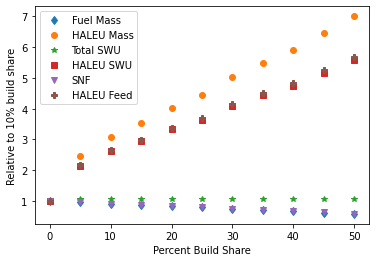

In [30]:
plt.figure
for index, key in enumerate(metrics): 
    plt.plot(xe100_data['xe100'], xe100_data[key]/xe100_data[key][0],label=metrics[key], 
            linestyle='None', marker = markers[index])
plt.xlabel('Percent Build Share')
plt.legend()
plt.ylabel('Relative to 10% build share')
plt.savefig('figures/xe100.pdf')

In [31]:
xe100_results = pd.DataFrame(columns=['Metric','Minimum','Maximum','Average','Standard Deviation'])
for key in metrics:
    minimum = xe100_data[key].min()
    maximum = xe100_data[key].max()
    average = xe100_data[key].mean()
    std = xe100_data[key].std()
    xe100_results.loc[len(xe100_results)] = [metrics[key], minimum, maximum, average, std]

In [32]:
xe100_results

,Metric,Minimum,Maximum,Average,Standard Deviation
0,Fuel Mass,7.733121e+07,1.345558e+08,1.051672e+08,1.844898e+07
1,HALEU Mass,2.713372e+06,1.901488e+07,1.194617e+07,4.921877e+06
2,Total SWU,1.012226e+09,1.078443e+09,1.070783e+09,1.945681e+07
3,HALEU SWU,1.224227e+08,6.835503e+08,4.416356e+08,1.690061e+08
4,SNF,6.602252e+07,1.129138e+08,8.882900e+07,1.511231e+07
5,HALEU Feed,1.038090e+08,5.912689e+08,3.809912e+08,1.468541e+08


In [34]:
#Deployment scheme
xe100_reactors = {}
percents = np.linspace(0,50, 11)
for percent in percents:
    xe100_reactors[str(percent)] = {'Xe-100':np.zeros(1499), 'MMR':np.zeros(1499),'VOYGR':np.zeros(1499)}
    DI = cdi.convert_xml_to_dict("xe-100/xe100_" + str(int(percent)) +"_deployinst.xml")
    for key in xe100_reactors[str(percent)]:
        for index, item in enumerate(DI['DeployInst']['prototypes']['val']):
            if item == key:
                start = int(DI['DeployInst']['build_times']['val'][index])
                end = int(DI['DeployInst']['build_times']['val'][index]) + int(DI['DeployInst']['lifetimes']['val'][index])
                if end > 1499:
                    end = 1499
                xe100_reactors[str(percent)][key][start:end] += int(DI['DeployInst']['n_build']['val'][index]) 

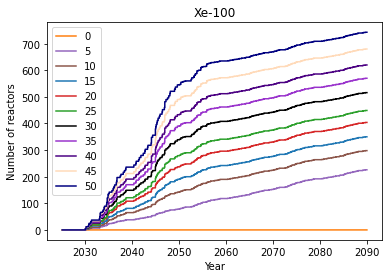

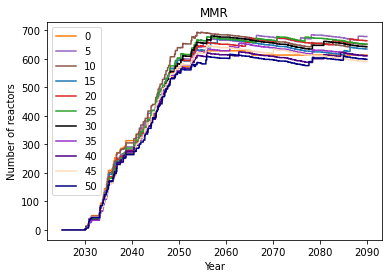

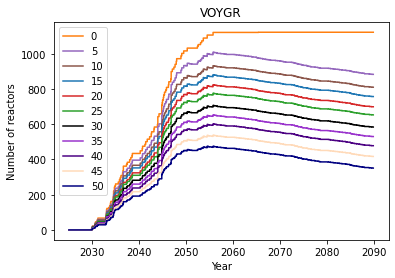

In [69]:
for p_index, percent in enumerate(percents):
    for index, reactor in enumerate(['Xe-100','MMR','VOYGR']):
        plt.figure(index)
        plt.step(time[721:], xe100_reactors[str(percent)][reactor][721:], 
                 label=str(int(percent)), color=colors[p_index])
        plt.legend()
        plt.title(reactor)
        plt.xlabel('Year')
        plt.ylabel('Number of reactors')
        plt.savefig(f'figures/{reactor}_xe100.pdf')

## MMR 
The new build share is specified for the MMR, ranging from 0-50% 
in increments of 5%. 

In [36]:
mmr_file = "mmr/mmr_build.dat"
mmr_data = pd.read_csv(mmr_file, sep="\s+",header=0)

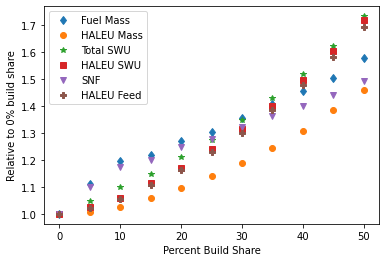

In [37]:
plt.figure
for index, key in enumerate(metrics): 
    plt.plot(mmr_data['mmr'], mmr_data[key]/mmr_data[key][0],label=metrics[key], 
            linestyle='None', marker = markers[index])
plt.xlabel('Percent Build Share')
plt.legend()
plt.ylabel('Relative to 0% build share')
plt.savefig('figures/mmr.pdf')

In [38]:
mmr_results = pd.DataFrame(columns=['Metric','Minimum','Maximum','Average','Standard Deviation'])
for key in metrics:
    minimum = mmr_data[key].min()
    maximum = mmr_data[key].max()
    average = mmr_data[key].mean()
    std = mmr_data[key].std()
    mmr_results.loc[len(mmr_results)] = [metrics[key], minimum, maximum, average, std]

In [39]:
mmr_results

,Metric,Minimum,Maximum,Average,Standard Deviation
0,Fuel Mass,3.487446e+07,5.503487e+07,4.566083e+07,6.060037e+06
1,HALEU Mass,2.567986e+07,3.747984e+07,3.014525e+07,4.060205e+06
2,Total SWU,9.472689e+08,1.641505e+09,1.242956e+09,2.282845e+08
3,HALEU SWU,8.852147e+08,1.523026e+09,1.138242e+09,2.159062e+08
4,SNF,3.169066e+07,4.726651e+07,4.038585e+07,4.738327e+06
5,HALEU Feed,7.688882e+08,1.302682e+09,9.799999e+08,1.808883e+08


In [40]:
#Deployment scheme
mmr_reactors = {}
percents = np.linspace(0,50, 11)
for percent in percents:
    mmr_reactors[str(percent)] = {'Xe-100':np.zeros(1499), 'MMR':np.zeros(1499),'VOYGR':np.zeros(1499)}
    DI = cdi.convert_xml_to_dict("mmr/mmr_" + str(int(percent)) +"_deployinst.xml")
    for key in mmr_reactors[str(percent)]:
        for index, item in enumerate(DI['DeployInst']['prototypes']['val']):
            if item == key:
                start = int(DI['DeployInst']['build_times']['val'][index])
                end = int(DI['DeployInst']['build_times']['val'][index]) + int(DI['DeployInst']['lifetimes']['val'][index])
                if end > 1499:
                    end = 1499
                mmr_reactors[str(percent)][key][start:end] += int(DI['DeployInst']['n_build']['val'][index])

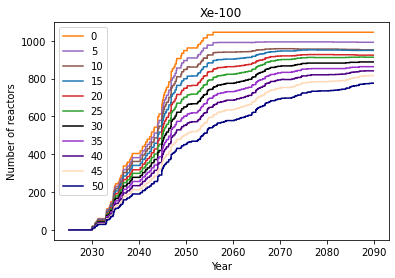

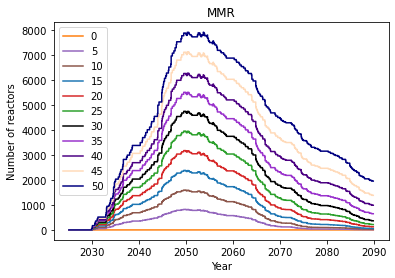

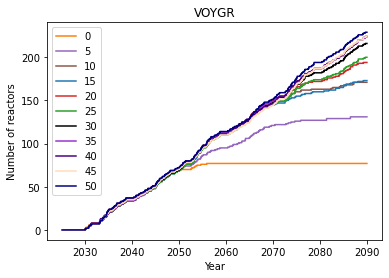

In [68]:
for p_index, percent in enumerate(percents):
    for index, reactor in enumerate(['Xe-100','MMR','VOYGR']):
        plt.figure(index)
        plt.step(time[721:], mmr_reactors[str(percent)][reactor][721:], 
                 label=str(int(percent)), color=colors[p_index])
        plt.legend()
        plt.title(reactor)
        plt.xlabel('Year')
        plt.ylabel('Number of reactors')
        plt.savefig(f'figures/{reactor}_mmr.pdf')

## VOYGR
The new build share is specified for the VOYGR, ranging from 0-50% 
in increments of 5%. 

In [42]:
voygr_file = "voygr/voygr_build.dat"
voygr_data = pd.read_csv(voygr_file, sep="\s+",header=0)

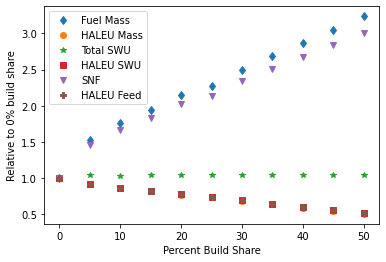

In [43]:
plt.figure
for index, key in enumerate(metrics): 
    plt.plot(voygr_data['voygr'], voygr_data[key]/voygr_data[key][0],label=metrics[key], 
            linestyle='None', marker = markers[index])
plt.xlabel('Percent Build Share')
plt.legend()
plt.ylabel('Relative to 0% build share')
plt.savefig('figures/voygr.pdf')

In [44]:
voygr_results = pd.DataFrame(columns=['Metric','Minimum','Maximum','Average','Standard Deviation'])
for key in metrics:
    minimum = voygr_data[key].min()
    maximum = voygr_data[key].max()
    average = voygr_data[key].mean()
    std = voygr_data[key].std()
    voygr_results.loc[len(voygr_results)] = [metrics[key], minimum, maximum, average, std]

In [45]:
voygr_results

,Metric,Minimum,Maximum,Average,Standard Deviation
0,Fuel Mass,2.929966e+07,9.479276e+07,6.658511e+07,2.003279e+07
1,HALEU Mass,1.485266e+07,2.929966e+07,2.159773e+07,4.620543e+06
2,Total SWU,1.039607e+09,1.083580e+09,1.077081e+09,1.252001e+07
3,HALEU SWU,5.430819e+08,1.039607e+09,7.734616e+08,1.580611e+08
4,SNF,2.654308e+07,7.965305e+07,5.663224e+07,1.630722e+07
5,HALEU Feed,4.689966e+08,9.004023e+08,6.692882e+08,1.373961e+08


In [46]:
#Deployment scheme
voygr_reactors = {}
percents = np.linspace(0,50, 11)
for percent in percents:
    voygr_reactors[str(percent)] = {'Xe-100':np.zeros(1499), 'MMR':np.zeros(1499),'VOYGR':np.zeros(1499)}
    DI = cdi.convert_xml_to_dict("voygr/voygr_" + str(int(percent)) +"_deployinst.xml")
    for key in voygr_reactors[str(percent)]:
        for index, item in enumerate(DI['DeployInst']['prototypes']['val']):
            if item == key:
                start = int(DI['DeployInst']['build_times']['val'][index])
                end = int(DI['DeployInst']['build_times']['val'][index]) + int(DI['DeployInst']['lifetimes']['val'][index])
                if end > 1499:
                    end = 1499
                voygr_reactors[str(percent)][key][start:end] += int(DI['DeployInst']['n_build']['val'][index])

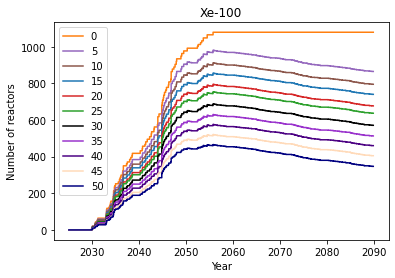

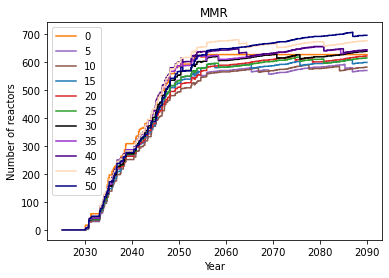

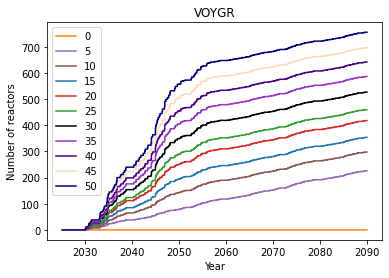

In [70]:
for p_index, percent in enumerate(percents):
    for index, reactor in enumerate(['Xe-100','MMR','VOYGR']):
        plt.figure(index)
        plt.step(time[721:], voygr_reactors[str(percent)][reactor][721:], 
                 label=str(int(percent)), color=colors[p_index])
        plt.legend()
        plt.title(reactor)
        plt.xlabel('Year')
        plt.ylabel('Number of reactors')
        plt.savefig(f'figures/{reactor}_voygr.pdf')